In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch import optim
from torch.utils.data import DataLoader

from data.datasets.ffhq_dataset import FFHQDataset
from data.datasources.ffhq_datasource import FFHQDatasource
from data.datasources.golden_age_face_datasource import GoldenAgeFaceDatasource
from functional.losses.bi_discriminator_loss import BidirectionalDiscriminatorLoss, BidirectionalDiscriminatorLossType
from networks.bigan import BiGAN
from training.bigan_trainer import BiGANTrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *

from data.datasets import facedataset
from data.datasources import facedatasource
from data.datasources.datasource_mode import DataSourceMode
from networks.siamese_network import SiameseNetwork
from functional.losses.contrastive_loss import ContrastiveLoss
from functional.metrics.dissimilarity import *
from training.face_recognition_trainer import train_epochs
from configs.base_config import *

In [3]:
def save_best_loss_model(model_name, model, best_loss):
    # print('current best loss: ' + str(best_loss))
    logging.info('current best loss: ' + str(best_loss))
    torch.save(model, base_dir + 'playground/bigan/results/' + model_name + ".pth")

In [5]:
golden_age_config = read_config(Config.GOLDEN_AGE_FACE)
datasource = GoldenAgeFaceDatasource(golden_age_config, mode=DataSourceMode.TRAIN)

reading image: 0
reading image: 512
reading image: 1024
reading image: 1536
reading image: 2048
reading image: 2560
reading image: 3072
reading image: 3584
reading image: 4096
reading image: 4608
reading image: 5120
reading image: 5632
reading image: 6144
reading image: 6656
reading image: 7168
reading image: 7680
reading image: 8192
reading image: 8704
reading image: 9216
reading image: 9728
reading image: 10240
reading image: 10752
reading image: 11264
reading image: 11776
reading image: 12288
reading image: 12800
reading image: 13312
reading image: 13824
reading image: 14336
reading image: 14848
reading image: 15360
reading image: 15872
reading image: 16384
reading image: 16896
reading image: 17408
reading image: 17920
reading image: 18432
reading image: 18944
reading image: 19456
reading image: 19968
reading image: 20480
reading image: 20992
reading image: 21504
reading image: 22016
reading image: 22528
reading image: 23040
reading image: 23552
reading image: 24064
reading image: 2

KeyboardInterrupt: 

In [10]:
annot_path = golden_age_config.annotations_folder_path
additional_data = datasource.get_additional_data(annot_path=annot_path,
                               from_image_count=70000,
                               additional_image_count=30000)

skipping image: 512
skipping image: 1024
skipping image: 1536
skipping image: 2048
skipping image: 2560
skipping image: 3072
skipping image: 3584
skipping image: 4096
skipping image: 4608
skipping image: 5120
skipping image: 5632
skipping image: 6144
skipping image: 6656
skipping image: 7168
skipping image: 7680
skipping image: 8192
skipping image: 8704
skipping image: 9216
skipping image: 9728
skipping image: 10240
skipping image: 10752
skipping image: 11264
skipping image: 11776
skipping image: 12288
skipping image: 12800
skipping image: 13312
skipping image: 13824
skipping image: 14336
skipping image: 14848
skipping image: 15360
skipping image: 15872
skipping image: 16384
skipping image: 16896
skipping image: 17408
skipping image: 17920
skipping image: 18432
skipping image: 18944
skipping image: 19456
skipping image: 19968
skipping image: 20480
skipping image: 20992
skipping image: 21504
skipping image: 22016
skipping image: 22528
skipping image: 23040
skipping image: 23552
skipping

In [ ]:
datasource.data = np.concatenate((datasource.data, additional_data), axis=0)

In [ ]:
train_config = read_config(Config.BiGAN)
train_dataset = FFHQDataset(datasource=datasource)
train_dataloader = DataLoader(train_dataset, batch_size=train_config.batch_size, shuffle=True)

In [ ]:
def train_golden_age_face_bigan(model_name='test_model'):
    logging.info("initiate training")
    net = BiGAN(image_dim=golden_age_config.image_dim).to(ptu.device)
    criterion = BidirectionalDiscriminatorLoss(loss_type=BidirectionalDiscriminatorLossType.VANILLA_LOG_MEAN)

    d_optimizer = torch.optim.Adam(net.discriminator.parameters(),
                                   lr=train_config.discriminator_lr,
                                   betas=(train_config.discriminator_beta_1, train_config.discriminator_beta_2),
                                   weight_decay=train_config.discriminator_weight_decay)

    g_optimizer = torch.optim.Adam(list(net.encoder.parameters()) + list(net.generator.parameters()),
                                   lr=train_config.generator_lr,
                                   betas=(train_config.generator_beta_1, train_config.generator_beta_2),
                                   weight_decay=train_config.generator_weight_decay)
    g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer,
                                                    lambda epoch: (
                                                                          train_config.train_epochs - epoch) / train_config.train_epochs,
                                                    last_epoch=-1)
    d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer,
                                                    lambda epoch: (
                                                                          train_config.train_epochs - epoch) / train_config.train_epochs,
                                                    last_epoch=-1)
    trainer = BiGANTrainer(model=net,
                           criterion=criterion,
                           train_loader=train_dataloader,
                           test_loader=None,
                           epochs=train_config.train_epochs,
                           optimizer_generator=g_optimizer,
                           optimizer_discriminator=d_optimizer,
                           scheduler_gen=g_scheduler,
                           scheduler_disc=d_scheduler,
                           best_loss_action=lambda m, l: save_best_loss_model(model_name, m, l))
    losses = trainer.train_bigan()

    logging.info("completed training")
    save_training_plot(losses['discriminator_loss'],
                       losses['generator_loss'],
                       "Golden Age Face BiGAN Losses",
                       base_dir + 'playground/bigan/' + f'results/bigan_plot.png')
    return net

In [9]:
ptu.set_gpu_mode(True)
# visualize_data()
# visualize_golden_age_face_data()
# model = train_bigan(get_dt_string() + "_model")
model = train_golden_age_face_bigan(get_dt_string() + "_model")
# torch.save(model, base_dir + 'playground/bigan/results/' + "test_model.pth")
# model = torch.load("test_model.pth")

Epoch 0, discriminator_loss 0.6095, generator_loss -0.5989: 100%|██████████| 70000/70000 [00:10<00:00, 6607.40it/s]
Epoch 1, discriminator_loss 0.4447, generator_loss -0.4326: 100%|██████████| 70000/70000 [00:10<00:00, 6926.97it/s]
Epoch 2, discriminator_loss 0.4084, generator_loss -0.3868: 100%|██████████| 70000/70000 [00:09<00:00, 7043.41it/s]
Epoch 3, discriminator_loss 0.3390, generator_loss -0.3093: 100%|██████████| 70000/70000 [00:09<00:00, 7108.27it/s]
Epoch 4, discriminator_loss 0.2163, generator_loss -0.2167: 100%|██████████| 70000/70000 [00:09<00:00, 7204.62it/s]
Epoch 5, discriminator_loss nan, generator_loss nan: 100%|██████████| 70000/70000 [00:09<00:00, 7156.34it/s]       
Epoch 6, discriminator_loss nan, generator_loss nan: 100%|██████████| 70000/70000 [00:10<00:00, 6911.76it/s]
Epoch 7, discriminator_loss nan, generator_loss nan: 100%|██████████| 70000/70000 [00:09<00:00, 7063.84it/s]
Epoch 8, discriminator_loss nan, generator_loss nan: 100%|██████████| 70000/70000 [00:

KeyboardInterrupt: 

In [4]:
config = read_config(Config.BiGAN)
train_dataset = FFHQDataset(
datasource=FFHQDatasource(config, mode=DataSourceMode.TRAIN))
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

reading image: 512
reading image: 1024
reading image: 1536
reading image: 2048
reading image: 2560
reading image: 3072
reading image: 3584
reading image: 4096
reading image: 4608
reading image: 5120
reading image: 5632
reading image: 6144
reading image: 6656
reading image: 7168
reading image: 7680
reading image: 8192
reading image: 8704
reading image: 9216
reading image: 9728
reading image: 10240
reading image: 10752
reading image: 11264
reading image: 11776
reading image: 12288
reading image: 12800
reading image: 13312
reading image: 13824
reading image: 14336
reading image: 14848
reading image: 15360
reading image: 15872
reading image: 16384
reading image: 16896
reading image: 17408
reading image: 17920
reading image: 18432
reading image: 18944
reading image: 19456
reading image: 19968
reading image: 20480
reading image: 20992
reading image: 21504
reading image: 22016
reading image: 22528
reading image: 23040
reading image: 23552
reading image: 24064
reading image: 24576
reading imag

In [5]:
def train_bigan(model_name='test_model'):
    logging.info("initiate training")
    net = BiGAN(image_dim=config.image_dim, latent_dim=config.latent_dim_z).to(ptu.device)
    criterion = BidirectionalDiscriminatorLoss(loss_type=BidirectionalDiscriminatorLossType.VANILLA_LOG_MEAN)

    d_optimizer = torch.optim.Adam(net.discriminator.parameters(),
                                   lr=config.discriminator_lr,
                                   betas=(config.discriminator_beta_1, config.discriminator_beta_2),
                                   weight_decay=config.discriminator_weight_decay)

    g_optimizer = torch.optim.Adam(list(net.encoder.parameters()) + list(net.generator.parameters()),
                                   lr=config.generator_lr,
                                   betas=(config.generator_beta_1, config.generator_beta_2),
                                   weight_decay=config.generator_weight_decay)
    g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer,
                                                    lambda epoch: (config.train_epochs - epoch) / config.train_epochs,
                                                    last_epoch=-1)
    d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer,
                                                    lambda epoch: (config.train_epochs - epoch) / config.train_epochs,
                                                    last_epoch=-1)
    trainer = BiGANTrainer(model=net,
                           criterion=criterion,
                           train_loader=train_dataloader,
                           test_loader=None,
                           epochs=config.train_epochs,
                           optimizer_generator=g_optimizer,
                           optimizer_discriminator=d_optimizer,
                           scheduler_gen=g_scheduler,
                           scheduler_disc=d_scheduler,
                           best_loss_action=lambda m, l: save_best_loss_model(model_name, m, l))
    losses = trainer.train_bigan()

    logging.info("completed training")
    save_training_plot(losses['discriminator_loss'],
                       losses['generator_loss'],
                       "BiGAN Losses",
                       base_dir + 'playground/bigan/' + f'results/bigan_plot.png')
    return net


Epoch 0, discriminator_loss 0.3721, generator_loss -0.3500: 100%|██████████| 30000/30000 [00:11<00:00, 2568.16it/s]
Epoch 1, discriminator_loss 0.2520, generator_loss -0.2198: 100%|██████████| 30000/30000 [00:11<00:00, 2676.11it/s]
Epoch 2, discriminator_loss 0.2141, generator_loss -0.1978: 100%|██████████| 30000/30000 [00:11<00:00, 2586.64it/s]
Epoch 3, discriminator_loss 0.2127, generator_loss -0.1976: 100%|██████████| 30000/30000 [00:12<00:00, 2471.59it/s]
Epoch 4, discriminator_loss 0.2586, generator_loss -0.2358: 100%|██████████| 30000/30000 [00:11<00:00, 2637.02it/s]
Epoch 5, discriminator_loss 0.3061, generator_loss -0.2855: 100%|██████████| 30000/30000 [00:11<00:00, 2677.30it/s]
Epoch 6, discriminator_loss 0.1795, generator_loss -0.1662: 100%|██████████| 30000/30000 [00:11<00:00, 2571.36it/s]
Epoch 7, discriminator_loss 0.1665, generator_loss -0.1419: 100%|██████████| 30000/30000 [00:11<00:00, 2598.64it/s]
Epoch 8, discriminator_loss 0.0376, generator_loss -0.0353: 100%|███████

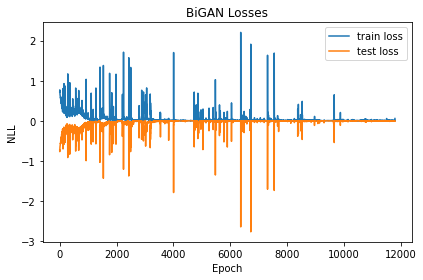

In [6]:
ptu.set_gpu_mode(True)
model = train_bigan(get_dt_string() + "_model")
